# Oct 29, 2025: distinct community shapes
and effective number of shapes

conda env: ckm

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# from munkres import Munkres

from pyckmeans import CKmeans, MultiCKMeans

# networks
# import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 110/110 [00:00<00:00, 1005.62it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
# pis_df

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [18]:
args.select_comms = np.arange(0, 9) # for pi_1_aligned only
i = 1
cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols1],
        pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        pis_df[cols2],
    ],
    axis=1
)

In [19]:
pis_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.0, 0.0503875...","[[0.26990405650233273, 0.6440288789416553, 0.0...","[[0.9201526698804413, 0.06128537650572014, 0.0...","[[0.9878395515527075, 0.009976689198605605, 0....","[[0.9957242760577405, 0.004275723942259544, 0....","[[0.997149517371827, 0.0028504826281730293, 0....","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1,grp,sbm-nd-h,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.2577782484379964, 0.6056505825165969, 0.10...","[[0.9229028897536316, 0.04418924874364539, 0.0...","[[0.9832180171575026, 0.009469124730781155, 0....","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0018282145279290526, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
2,grp,sbm-nd-h,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.062295288485764676, 0.837962962962963, 0.0...","[[0.990532053055227, 0.0034393706396990465, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,grp,sbm-nd-h,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.15702479338842976, 0.768595041322314, 0.06...","[[0.8881112654215585, 0.10046874960473759, 0.0...","[[0.998572501878287, 0.0, 0.001427498121712997...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
4,grp,sbm-nd-h,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.6071850227694383, 0.27862602196163366, 0.0...","[[0.9291409601437918, 0.015660401422622795, 0....","[[0.9874163597969866, 0.0046981204267868395, 0...","[[0.9905484400815112, 0.00156604014226228, 0.0...","[[0.9921144802237735, 0.0, 0.00788551977622647...","[[0.9921144802237735, 0.00788551977622647, 0.0...","[[0.9921144802237735, 0.00788551977622647, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.975609756097561, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8958754709498316, 0.023795359904818562, 0....","[[0.0808199036613937, 0.8079089746876055, 0.08...","[[0.9531361388326043, 0.04109101090586787, 0.0...","[[1.0000000000000002, 0.0, 0.0, 0.0], [0.99999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999..."
1272,89,sbm-nd-h,0.038413,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.42105263157894735, 0.0, 0.5789473684210527...","[[0.060403200984918436, 0.9013542628501078, 0....","[[0.9708477102266285, 0.029152289773371563, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1273,89,sbm-nd-h,0.030960,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12903225806451613, 0.0, 0.8709677419354839...","[[0.008324661810613945, 0.9146722164412071, 0....","[[0.9990750375765985, 0.0, 0.00092496242340154...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 

testing

In [20]:
# simulate dataset
# 50 samples, 2 features, 3 true clusters
import sklearn.datasets
x_, _ = sklearn.datasets.make_blobs(n_samples=50, n_features=2, centers=3, random_state=75)
x = np.random.randn(75, 2)
x = 0.1 * x
x[:50, :] = x_

scaler = StandardScaler()
x = scaler.fit_transform(x)

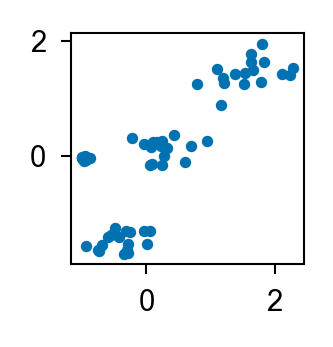

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(1.0, 1.0))
ax.scatter(x[:, 0], x[:, 1], s=3, c=CUD_COLORS[0])

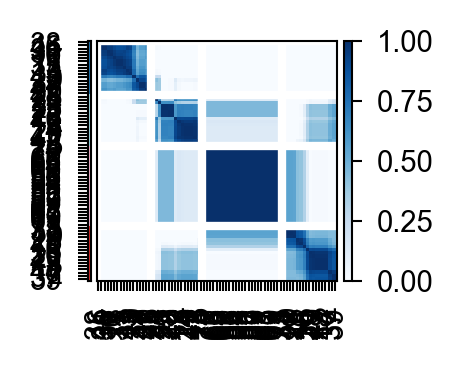

In [22]:
ckm = CKmeans(k=4, n_rep=100, p_samp=0.8, p_feat=0.5)
ckm.fit(x)
ckm_res = ckm.predict(x)
fig = ckm_res.plot(figsize=(1, 1))

In [23]:
ckm_res.cl

array([0, 3, 1, 0, 3, 3, 1, 0, 3, 1, 0, 0, 3, 0, 3, 3, 1, 1, 1, 1, 0, 1,
       3, 3, 3, 3, 1, 0, 3, 3, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 3, 1, 3, 3,
       1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [24]:
mckm = MultiCKMeans(k=[2, 3, 4, 5], n_rep=100, p_samp=0.8, p_feat=0.5)
mckm.fit(x)
mckm_res = mckm.predict(x)

In [25]:
mckm_res.metrics

,k,sil,bic,db,ch
0,2,0.606188,-21.390508,0.543827,144.880426
1,3,0.654876,-79.057176,0.522471,209.540358
2,4,0.639736,-115.116472,0.476477,252.876546
3,5,0.568406,-115.641349,0.551161,200.624339


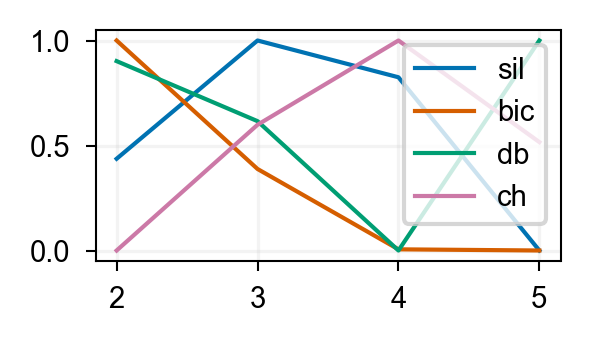

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
df = mckm_res.metrics
for i, metric in enumerate(df.columns[1:]):
    vals = df[metric]
    vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
    ax.plot(df['k'], vals, c=CUD_COLORS[i], label=metric)
ax.legend()
ax.grid(alpha=0.15)

array([[1.  , 0.14, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.14, 1.  , 0.07, ..., 0.59, 0.59, 0.59],
       [0.  , 0.07, 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.59, 0.  , ..., 1.  , 1.  , 1.  ],
       [0.  , 0.59, 0.  , ..., 1.  , 1.  , 1.  ],
       [0.  , 0.59, 0.  , ..., 1.  , 1.  , 1.  ]])

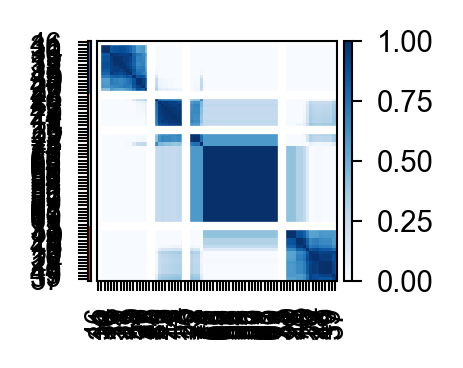

In [27]:
ckm_res_k3 = mckm_res.ckmeans_results[2]
ckm_res_k3.plot(figsize=(1, 1))
ckm_res_k3.cmatrix

unique shapes

In [28]:
def compute_cluster_probabilities(clusters, omegas, num_clusters):
    # if len(omegas) > 1:
        return np.bincount(clusters, weights=omegas, minlength=num_clusters)
    # else:
    #     return np.array([1.0])

def compute_effective_number_of_shapes(probs):
    return np.exp(stats.entropy(probs))

def get_unique_configs(config_matrix, clusters):
    # encdr : num_modes x num_clusters
    encdr = OneHotEncoder(
        sparse_output=False,
    ).fit_transform(clusters.reshape(-1, 1))
    # mean configuration within each cluster, 
    # config_matrix.T : num_rois x num_modes
    # cluster_configs : num_rois x num_clusters (per comm)
    unique_configs =  np.round(
        config_matrix.T @ encdr / encdr.sum(axis=0),
        decimals=3,
    )
    return unique_configs

| metric | better |
| --- | --- | 
| sil | higher |
| bic | lower |
| db | lower |
| ch | higher |

In [73]:
args.standardize = True

In [74]:
ckm_res_df = []
for col in cols[1:2]:
    Ms = np.stack(pis_df[col].to_list()) # data_points x rois x comms
    num_points, num_rois, num_comms = Ms.shape
    
    for comm in tqdm(range(num_comms)):
        try:
            scaler = StandardScaler()
            data = Ms[:, :, comm]
            if args.standardize: 
                data = scaler.fit_transform(data)
            
            # ckm = CKmeans(k=3, n_rep=100, p_samp=0.8, p_feat=0.75, )
            # ckm.fit(data)
            # ckm_res = ckm.predict(data)
            
            ks = np.arange(2, 15)
            mckm = MultiCKMeans(k=ks, n_rep=100, p_samp=0.8, p_feat=0.75)
            mckm.fit(data)
            mckm_res = mckm.predict(data)
            
            ckm_res_df += [pd.DataFrame({
                'comm': [f'C. {comm+1:02d}'],
                'res':[mckm_res],
            })]
            
            # break
        except:
            pass
        # break
ckm_res_df = pd.concat(ckm_res_df).reset_index(drop=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [12:52<00:00, 85.84s/it]


In [75]:
def plot_metrics(ax, comm, mckm_res): 
    df = mckm_res.metrics
    for i, metric in enumerate(df.columns[1:]):
        vals = df[metric]
        vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
        label = metric
        label += r'$\uparrow$' if metric in ['sil', 'ch'] else r'$\downarrow$'
        ax.plot(df['k'], vals, c=CUD_COLORS[i], label=label)
    ax.set(ylabel=f'{comm}', xlabel=f'Number of clusters ' + r'$k$',)
    ax.legend()
    ax.grid(alpha=0.15)
    return ax

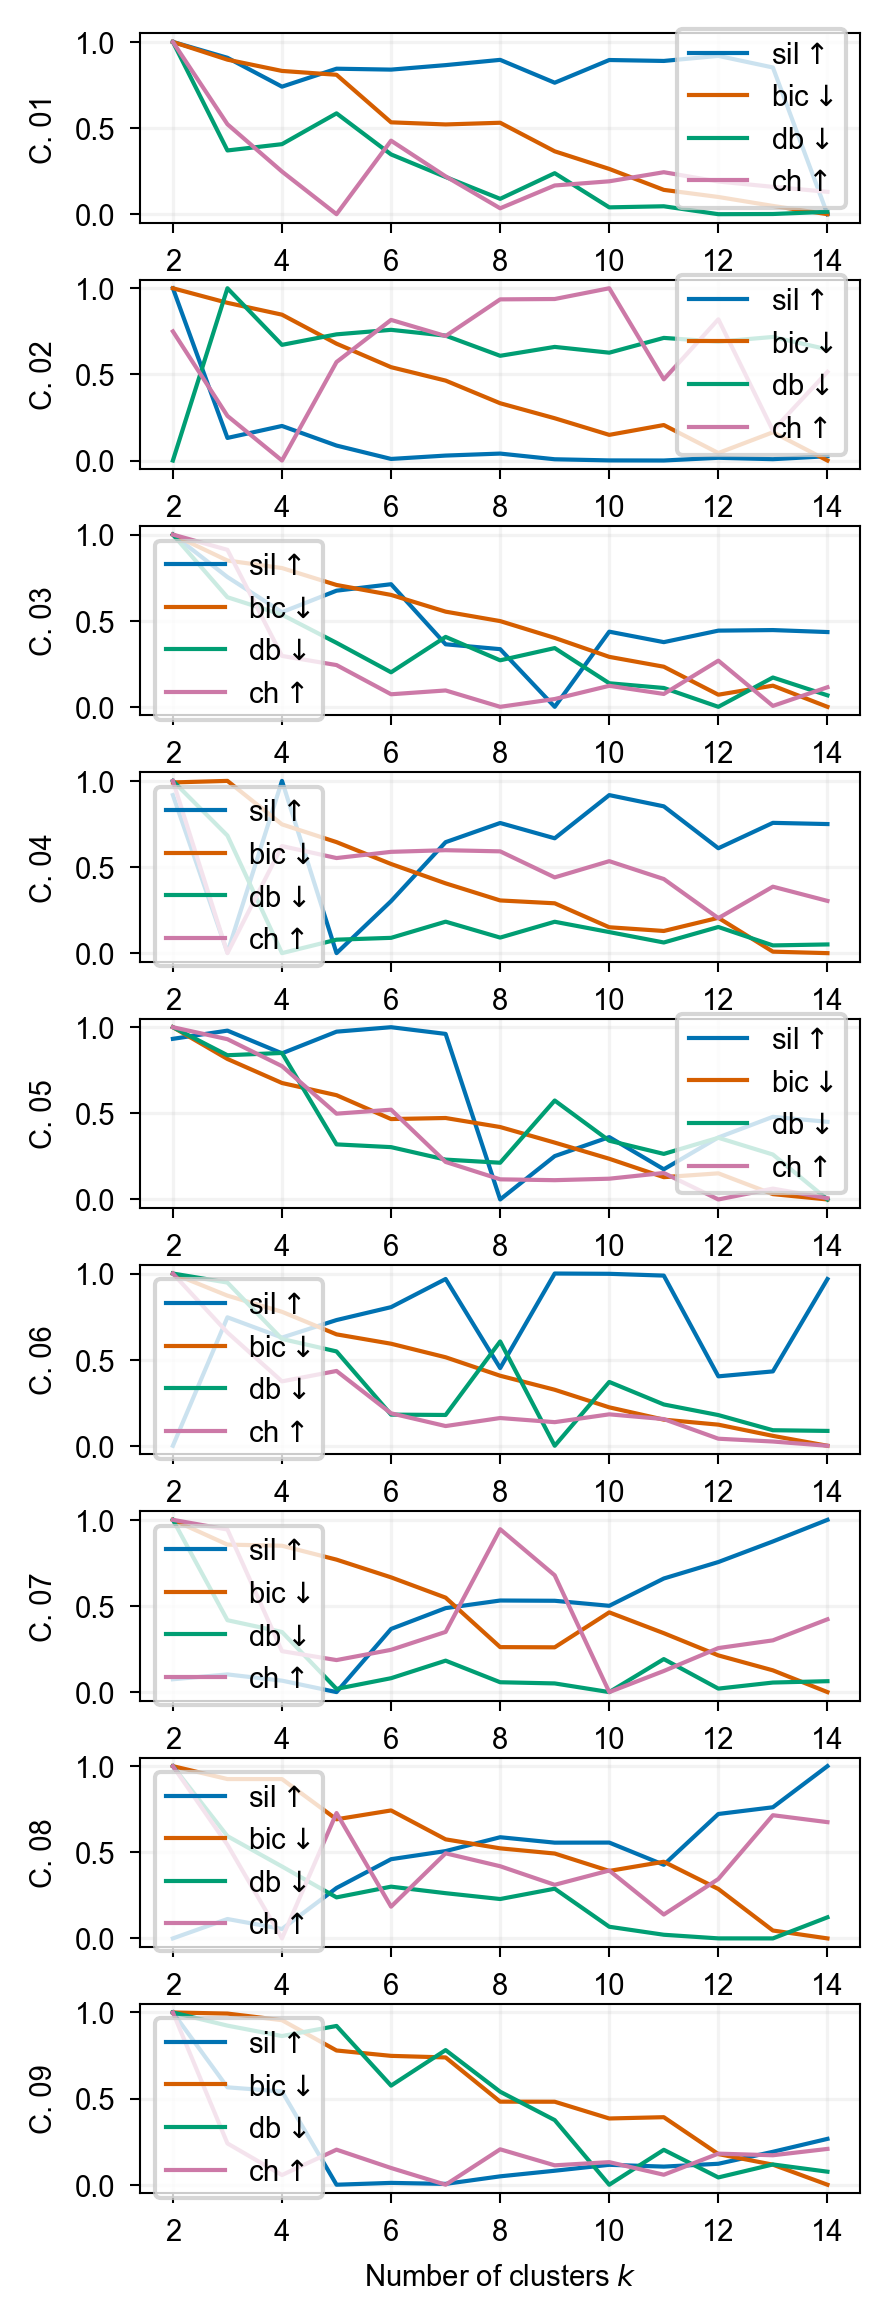

In [76]:
num_comms = len(ckm_res_df)
nrows = num_comms
ncols = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 1*nrows), dpi=300)
fig.subplots_adjust(
    left=0.1,    # Increase if y-axis labels are cut off
    right=0.9,   # Decrease if there's too much margin on the right
    bottom=0.1,  # Increase if x-axis labels are cut off
    top=0.9,     # Decrease if titles are cut off
    wspace=0.3,  # Width between subplots
    hspace=0.3,  # Height between subplots
)

for idx, row in ckm_res_df.iterrows():
    comm = row['comm']
    mckm_res = row['res']
    ax = axs[idx]
    ax = plot_metrics(ax, comm, mckm_res)

In [77]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/ckmeans-metrics-distribution'
os.makedirs(folder, exist_ok=True)
level = col.replace('pi', '').replace('_', '').replace('aligned', '')
fig.savefig(f'{folder}/level-{level}_standardize-{args.standardize}.svg', transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
analysis_df = []
centroids_df = []

for col in cols[1:2]:
    Ms = np.stack(pis_df[col].to_list())
    num_comms = Ms.shape[-1]

    for comm in range(num_comms):
        try:
            centroids, labels, scores, k = find_archetypes_per_comm(Ms[:, :, comm], max_k=10)
            comm_df = pd.concat(
                [
                    pis_df[['sub', 'sbm', 'omega']],
                    pd.Series(labels, name='labels'),
                ],
                axis=1,
            )
            
            for sub, group in comm_df.groupby('sub'):
                clusters = np.array(group['labels'].to_list())
                omegas = group['omega']
                ps = compute_cluster_probabilities(
                    clusters, omegas, k,
                )
                eff_num_shapes = compute_effective_number_of_shapes(ps)
                
                Cs = np.stack(pis_df[(pis_df['sub'] == sub)][col].to_list())
                unique_configs = get_unique_configs(Cs[:, :, comm], clusters)
                
                arow = pd.DataFrame(dict(
                    sub=[sub],
                    sbm=[SBM],
                    col=[col],
                    comm=[comm],
                    clusters=[clusters],
                    eff_num_shapes=[eff_num_shapes],
                    strengths=[ps],
                    configs=[np.round(unique_configs, decimals=3)],
                    scores=[scores],
                ))
                analysis_df += [arow]
                
            crow = pd.DataFrame(dict(
                sbm=[SBM],
                col=[col],
                comm=[comm],
                centroids=[np.round(centroids, decimals=3)],
            ))
            centroids_df += [crow]
                # break
        except:
            pass
analysis_df = pd.concat(analysis_df).reset_index(drop=True)
centroids_df = pd.concat(centroids_df).reset_index(drop=True)

In [ ]:
analysis_df[analysis_df['col'].isin(['pi_1_aligned'])]

In [ ]:
centroids_df

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/desc-centroids.pkl', 'wb') as f:
    pickle.dump(centroids_df, f)

WHICH are the most popular shapes of a comm. in the population: strengths?

In [ ]:
def plot_strengths(data, comm):
    num_forms = data.shape[1]
    fig, ax = plt.subplots(1, 1, figsize=(num_forms*0.5, 1), dpi=300)

    def connect_points(ax, data):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]-1):
                x1, x2 = j, j+1
                y1, y2 = data[i, x1], data[i, x2]
                color = 'grey' #CUD_COLORS[1] if y1 > y2 else CUD_COLORS[0]
                alpha = 0.15
                linewidth = 0.5
                linestyle = '-'
                ax.plot(
                    [x1, x2], [y1, y2], 
                    color=color, alpha=alpha, 
                    linewidth=linewidth, 
                    linestyle=linestyle,
                )
        return ax

    sns.boxplot(
        data=data, 
        ax=ax,
        color='grey',
        fill=False, 
        width=0.5, 
        linewidth=1,
        fliersize=0,
        capprops=dict(linewidth=0),
    )

    sns.stripplot(
        data=data, 
        ax=ax,
        color=CUD_COLORS[0],
        size=2,
        marker='o',
        alpha=0.5, 
        jitter=False,
    )

    ax = connect_points(ax, data)

    sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    ax.set(xticklabels=[f'T. {i}' for i in range(num_forms)])
    ax.set(ylabel=f'C. {comm+1:02d}')
    ax.grid(alpha=0.15)
    return fig

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/strength-distribution'
os.makedirs(folder, exist_ok=True)

col = cols[1]
comms = analysis_df[analysis_df['col'].isin([col])]['comm'].unique()
    
for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    for comm in comms:
        Ss = np.stack(analysis_df[analysis_df['col'].isin([col])][analysis_df['comm'].isin([comm])]['strengths'].to_list())
        Ss = np.round(Ss, decimals=3)
        fig = plot_strengths(Ss, comm)
        fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.svg', transparent=True, dpi=300, bbox_inches='tight')
        fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.png', transparent=True, dpi=300, bbox_inches='tight')

HOW many shapes does a comm. adopt in a sample of mice: effective number of distinct shapes

In [ ]:
def plot_effective_numbers(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='eff_num_shapes',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='eff_num_shapes',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        # ax.scatter(0, group['eff_num_shapes'].median(), c=CUD_COLORS[1], s=10)
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[1-0.05, 3.5], yticks=[1, 2, 3])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = analysis_df[analysis_df['col'].isin([col])]
    g = plot_effective_numbers(long_df)
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.png', transparent=True, dpi=300, bbox_inches='tight')

WHERE do transitions to alternate shapes happen: distributed across modes or concentrated in a few?

In [ ]:
shape_transitions_df = []
for (col, sub), group in analysis_df.groupby(by=['col', 'sub']):
    # print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    
    comm_clusters = np.stack(group['clusters'].to_list())
    num_rare_shapes = np.sum(comm_clusters > 0, axis=0)
    avg_transitions = np.median(num_rare_shapes) / comm_clusters.shape[0] # divide by num_comms

    row = dict(
        sub=sub,
        sbm=SBM,
        col=col,
        num_rare_shapes=num_rare_shapes,
        avg_transitions=avg_transitions,
    )
    shape_transitions_df += [row]
shape_transitions_df = pd.DataFrame(shape_transitions_df)
shape_transitions_df['col'] = shape_transitions_df['col'].map(
    lambda x: x.replace('pi', '').replace('_', '').replace('aligned', '')
)

In [ ]:
comm_clusters

In [ ]:
shape_transitions_df

In [ ]:
def plot_rare_transitions(long_df: pd.DataFrame):
    nrows = sorted(long_df['col'].unique())
    nrows = np.max([int(c) for c in nrows])+1 #len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (col,), group in long_df.groupby(by=['col']):
        col = int(col)
        ax = axs[col]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color='grey',
            fill=False, 
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylabel=f'Level {col}', ylim=[0, 1], yticks=[0, 0.5, 1],)
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

g = plot_rare_transitions(shape_transitions_df)
g.savefig(f'{folder}/desc-rare-transitions.svg', transparent=True, dpi=300, bbox_inches='tight')
g.savefig(f'{folder}/desc-rare-transitions.png', transparent=True, dpi=300, bbox_inches='tight')

HOW different are the shapes: stable fractions ?

In [ ]:
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
v = np.loadtxt(f'{ROI_SYS_path}/desc-roi-vox-counts.csv') # n_rois

In [ ]:
def compute_stable_fraction(strengths, configs, v, tol=0.01):
    comm_mask = ~np.all(configs <= tol, axis=1)
    diffs = np.abs(configs[comm_mask, :] - configs[comm_mask][:, [0]])
    wdiffs = diffs * strengths
    stable_frac = np.sum(v[comm_mask] * np.all(wdiffs <= tol, axis=1)) / np.sum(v * comm_mask) # account for voxels within ROIs
    stable_frac = np.round(stable_frac, decimals=3)
    return np.nan_to_num(stable_frac)

In [ ]:
tol = 0.01
stable_fracs = analysis_df.apply(lambda row: compute_stable_fraction(row['strengths'], row['configs'], v, tol=tol), axis=1)

In [ ]:
stable_fracs_df = pd.concat(
    [
        analysis_df[['sub', 'sbm', 'col', 'comm']],
    ],
    axis=1,
)
stable_fracs_df['stable_frac'] = stable_fracs
stable_fracs_df[stable_fracs_df['col'].isin(cols[1:2])]

In [ ]:
def plot_stable_fractions(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[0-0.05, 1+0.05], yticks=[0, 0.5, 1])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = stable_fracs_df[stable_fracs_df['col'].isin([col])]
    g = plot_stable_fractions(long_df)
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.png', transparent=True, dpi=300, bbox_inches='tight')